In [48]:
import re
import urllib.request

In [49]:
url = ("https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
 "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x204dc7a2030>)

In [50]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
 raw_text = f.read()
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


Text-to-token

In [51]:
text = 'Hello, world. Is this-- a test?'
# match either a comma, a period..., OR any --, OR any whitespace
result = re.split(r'([,.?!:;_"()\']|--|\s)', text)
# bool(' '.strip()) -> False 
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [52]:
preprocessed = re.split(r'([,.?!:;_"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [53]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


Token-to-tokenID

In [54]:
# list of unique words = vocabulary
all_tokens = sorted(set(preprocessed))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])  # unkown tokens, unrelated tokens
vocab = {token: integer for integer, token in enumerate(all_tokens)}  # vocabulary dictionary type {token: id}

print(len(vocab.items()))

1132


In [55]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)


('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


Encoder and Decoder = Tokenizer

In [56]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab 
        self.int_to_str = {i:s for s,i in vocab.items()} 
 
    def encode(self, text): 
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
 
    def decode(self, ids): 
        text = " ".join([self.int_to_str[i] for i in ids]) 
 
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) 
        return text


In [57]:
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know," 
 Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [58]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab 
        self.int_to_str = {i:s for s,i in vocab.items()} 
 
    def encode(self, text): 
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
 
    def decode(self, ids): 
        text = " ".join([self.int_to_str[i] for i in ids]) 
 
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text) 
        return text

In [59]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [60]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


Byte pair encoding (BPE)

In [61]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [62]:
tokenizer = tiktoken.get_encoding("gpt2")

text = (
 "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
 "of someunknownPlace.")
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

strings = tokenizer.decode(integers)
print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


In [63]:
# Ex 2.1 unkown word
unknown_word = "Akwirw ier"
unknown_integers = tokenizer.encode(unknown_word)
print(unknown_integers)

unknown_strings = tokenizer.decode(unknown_integers)
print(unknown_strings)

[33901, 86, 343, 86, 220, 959]
Akwirw ier


Sliding window

In [64]:
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

enc_sample = enc_text[50:]

5145


Dataset for batched inputs and targets

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader

torch.cuda.is_available()

True

In [66]:
# text to 
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + 1 + max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    # single row with 2 tensors: input_chunk, target_chunk
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
# dataloader
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)   

    return dataloader                                                                           

In [67]:
with open ("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

# batch_size = how many samples to process in parallel each iteration
# stride = number of positions to shift inputs each batches
# max_length = sliding window size (number of columns)
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter) 
print(first_batch) 

second_batch = next(data_iter)
print(second_batch)



[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]
[tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]), tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]


In [68]:
# test batch sizes > 1
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("inputs:", inputs, "\ntsargets:", targets)



inputs: tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]]) 
tsargets: tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [69]:
input_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6
output_dim = 3

torch.manual_seed(123)
# Embedding layer with (vocab_size x output_dim) weight matrix, mapping input indices to dense vectors
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)  
print(embedding_layer.weight)  # weight matrix

# apply to input_ids to get embedding vector
#                                   2idx↓, 3idx↓, 5idx↓, 1idx↓
print(embedding_layer(torch.tensor([2,     3,     5,     1])))


Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Positional Token embedding layer

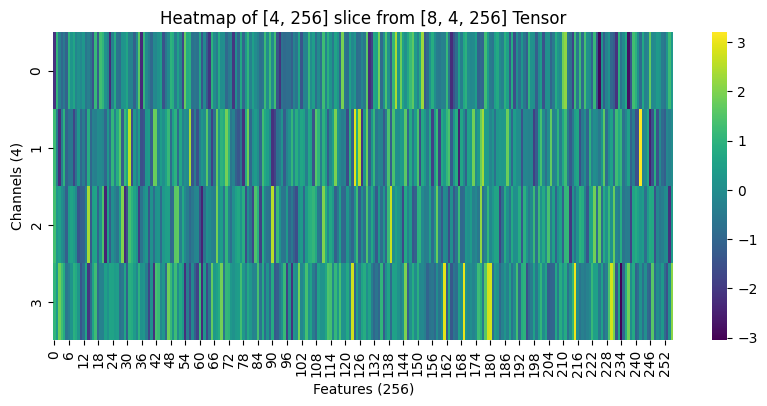

In [70]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Example tensor
tensor = torch.randn(8, 4, 256)

# Visualize the first sample as a heatmap
sample = tensor[0].numpy()
plt.figure(figsize=(10, 4))
sns.heatmap(sample, cmap='viridis')
plt.xlabel('Features (256)')
plt.ylabel('Channels (4)')
plt.title('Heatmap of [4, 256] slice from [8, 4, 256] Tensor')
plt.show()

# ↓ 8 of this stacked together
# 8 = number of stacks
# 4 = each token 
# 256 = each token represented as 256 vector

In [71]:
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(token_embedding_layer.weight.shape) # weight matrix

torch.Size([50257, 256])


In [72]:
# 8 sample with 4 token each
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)
data_ite = iter(dataloader)
iniputs, targets = next(data_iter)
print(f"token ids:\n {inputs}")
print(f"inputs shape:\n {iniputs.shape}")

token ids:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])
inputs shape:
 torch.Size([8, 4])


In [73]:
token_embeddings = token_embedding_layer(inputs)  # (8, 4)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [74]:
contex_length = max_length
pos_embedding_layer = torch.nn.Embedding(contex_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(contex_length))  # placeholder vector
print(pos_embeddings.shape)


torch.Size([4, 256])


In [75]:
# add pos_embeddings to token_embeddings = input_embeddings (read to be processes by LLM)
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Self attention (ch.3)

In [76]:
import torch
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

In [77]:
# calculate attention score ω(dot product of query token and all other input tokens)
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])  # uninitialized tensor
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)  # dot product

print(query)
print(attn_scores_2)

tensor([0.5500, 0.8700, 0.6600])
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [78]:
# attention weights α(normalize attention scores using softmax function)
# ~ torch.exp(x) / torch.exp(x).sum(dim=0) → e^x / sum(e^x_i)
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [79]:
# context vector z(2)
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)  # tensor([0., 0., 0.])
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i  # α_0 * x_0 + ... + α_T * x_T

print(query.shape)
print(context_vec_2)

torch.Size([3])
tensor([0.4419, 0.6515, 0.5683])


In [80]:
# all attention scores
attn_scores = torch.empty(inputs.shape[0], inputs.shape[0])  # (6, 6)
attn_scores = inputs @ inputs.T
# 2nd solution (slow)
# for i, x_i in enumerate(inputs):
#     for j, x_j in enumerate(inputs):
#         attn_scores[i, j] = torch.dot(x_i, x_j)
print("Attention scores:\n", attn_scores, "\n")

# all attention weights (normalize attention scores)
attn_weights = torch.softmax(attn_scores, dim=-1)
print("Attention weights:\n", attn_weights)
print("All row sums:\n", attn_weights.sum(dim=-1), "\n")

# all context vectors (matrix multiplication)
all_context_vec = attn_weights @ inputs
print("Context vectors:\n", all_context_vec, "\n")

# print("inputs:\n", inputs)
# print("inputs T:\n", inputs.T)

Attention scores:
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]]) 

Attention weights:
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
All row sums:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]) 

Context vectors:
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],

Self attention with trainable weights

In [81]:
x_2 = inputs[1] 
d_in = inputs.shape[1]  # 3
d_out = 2 

# weight matrices W_q, W_k, and W_v
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# compute query, key and value  vectors
query_2 = x_2 @ W_query
key_2 = inputs @ W_key
value_2 = inputs @ W_value
print(query_2)


tensor([0.4306, 1.4551])


In [82]:
# all keys and values
keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [83]:
# attention scores for 2nd query
attn_scores_2 = query_2 @ keys.T 
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [84]:
# normalize attention scores → attention weights (propability destributions)
d_k = keys.shape[-1]  # key dimension
attn_weights_2 = torch.softmax(attn_scores_2 / torch.sqrt(torch.tensor(d_k)), dim=-1)  # or (.. / d_k**0.5, dim=-1)
print(attn_weights_2)


tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [85]:
# single context vector for 2nd query
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


Orginize code in Python class

In [86]:
# self-attention class creation
import torch.nn as nn
class SelfAttentionScore_V1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))  # this will be updated with nn.Linear
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):  # x is input vector
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value 
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / torch.sqrt(torch.tensor(keys.shape[-1])), dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [87]:
# use self-attention class
torch.manual_seed(123)
sa_v1 = SelfAttentionScore_V1(d_in, d_out)  # object (3, 2)
print(sa_v1(inputs))  # (6,3)


tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [88]:
# nn.Linear uses a more sophisticated weight initialization scheme
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [89]:
# using SelfAttention_v2
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Exercise 3.1 Comparing SelfAttention_v1 and SelfAttention_v2  
   
> Note that nn.Linear in SelfAttention_v2 uses a different weight initialization  
> scheme as nn.Parameter(torch.rand(d_in, d_out)) used in SelfAttention_v1,  
> which causes both mechanisms to produce different results. To check that both  
> implementations, SelfAttention_v1 and SelfAttention_v2, are otherwise similar,  
> we can transfer the weight matrices from a SelfAttention_v2 object to a SelfAttention_v1,  
> such that both objects then produce the same results.  
> Your task is to correctly assign the weights from an instance of SelfAttention_v2  
> to an instance of SelfAttention_v1. To do this, you need to understand the relationship  
> between the weights in both versions. (Hint: nn.Linear stores the weight  
> matrix in a transposed form.) After the assignment, you should observe that both  
> instances produce the same outputs.



In [90]:
# ex 3.1
sa_v1.W_query.data = sa_v2.W_query.weight.data.T
sa_v1.W_key.data = sa_v2.W_key.weight.data.T
sa_v1.W_value.data = sa_v2.W_value.weight.data.T

output_v1 = sa_v1(inputs)
output_v2 = sa_v2(inputs)

print("v1 output:\n", output_v1)
print("v2 output:\n", output_v2)


v1 output:
 tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)
v2 output:
 tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


3.5 Casual Attention

In [91]:
queries = sa_v2.W_query(inputs) 
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [92]:
# efficient way
# apply mask
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))  # lower triangle
print(mask_simple)

masked_simple = attn_weights*mask_simple
# print(masked_simple)


# renormalize: sum of each row = 1
row_sums = masked_simple.sum(dim=-1, keepdim=True)  # [6,6] → [6,1]
masked_simple_norm = masked_simple / row_sums
print("normalized mask: ", masked_simple_norm)

# -inf above diagonal
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)  # upper triangle of ones
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)  # 1=True → -inf
print(masked, masked.shape)

# atten_weights = softmax of masked 
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
normalized mask:  tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)
tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>) torch.Size

Dropout - prevent overfitting

In [93]:
torch.manual_seed(123)  # generate same random numbers
dropout = torch.nn.Dropout(0.5)  # Dropout layer, 50% of values will be set to 0, remaining scaled up by 1 / (1 - 0.5) = 2
example = torch.ones(6, 6) 
print(dropout(example))

# apply dropout to attention weights
torch.manual_seed(123)
print(dropout(attn_weights))


tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


Casual attention class

In [94]:
class CausalAttention(nn.Module):
    """create query, key, value projection matrices from input
        softmax(Q*K + mask)*V
        casual mask blocks future tokens
        return weighted output
    """
    def __init__(self, d_in, d_out, context_length,
    dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)  # shape: (batch_size, context_length, d_out)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) 
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))  # mask moves with model to GPU

    def forward(self, x):
        b, num_tokens, d_in = x.shape 
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.transpose(1, 2) 
        attn_scores.masked_fill_( 
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec     


In [96]:
# use casual attention class
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 6, 3])
context_vecs.shape: torch.Size([2, 6, 2])


Multihead attention class with weight splits

In [97]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, 
    context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
        "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # num_heads * head_dim = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
        diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) 
        queries = self.W_query(x) 
        values = self.W_value(x) 
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) 
        queries = queries.view( 
        b, num_tokens, self.num_heads, self.head_dim 
        ) 
        keys = keys.transpose(1, 2) 
        queries = queries.transpose(1, 2) 
        values = values.transpose(1, 2) 
        attn_scores = queries @ keys.transpose(2, 3) 
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] 
        
        attn_scores.masked_fill_(mask_bool, -torch.inf) 
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        context_vec = context_vec.contiguous().view(
        b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec) 
        return context_vec
    

In [99]:
# use multihead attention 
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Exercise 3.3 Initializing GPT-2 size attention modules
> Using the MultiHeadAttention class, initialize a multi-head attention module that
>  has the same number of attention heads as the smallest GPT-2 model (12 attention
> heads). Also ensure that you use the respective input and output embedding sizes
> similar to GPT-2 (768 dimensions). Note that the smallest GPT-2 model supports a
> context length of 1,024 tokens.

In [100]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    
    def forward(self, x):
        attn_output, _ = self.multihead_attn(x, x, x)
        return attn_output

# GPT-2 smallest model configuration
embed_dim = 768   # Hidden size
num_heads = 12    # Number of attention heads
context_length = 1024  # Maximum context length

# Initialize the attention module
attention = MultiHeadAttention(embed_dim, num_heads)

# Create a sample input tensor (batch_size, context_length, embed_dim)
x = torch.randn(1, context_length, embed_dim)

# Forward pass
output = attention(x)

print(output.shape)  # Expected shape: (1, 1024, 768)


torch.Size([1, 1024, 768])
